In [1]:
"""
NOTE: MODIFIED BY SHAUN LOWIS, AUG 31st 2024

===========================================================
Case 4: Dropped sphere over non-rotating, spherical Earth
===========================================================

==============  ===============
Verifies        Gravitation, integration
Gravitation     :math:`1/R^2`
Geodesy         Round fixed
Atmosphere      US 1976 STD
Winds           still air
Vehicle         Sphere with constant :math:`C_D`
==============  ===============
"""

from simupy.block_diagram import BlockDiagram
import simupy_flight
import numpy as np

from nesc_testcase_helper import plot_nesc_comparisons, int_opts, benchmark
from nesc_testcase_helper import ft_per_m, kg_per_slug

planet = simupy_flight.Planet(
    gravity=simupy_flight.get_spherical_gravity(
        simupy_flight.earth_spherical_gravity_constant
    ),
    winds=simupy_flight.get_constant_winds(),
    atmosphere=simupy_flight.atmosphere_1976,
    planetodetics=simupy_flight.Planetodetic(
        a=20902255.199 / ft_per_m, omega_p=0.0, f=0.0
    ),
)

Ixx = 3.6 * kg_per_slug / (ft_per_m**2)  # slug-ft2
Iyy = 3.6 * kg_per_slug / (ft_per_m**2)  # slug-ft2
Izz = 3.6 * kg_per_slug / (ft_per_m**2)  # slug-ft2
Ixy = 0.0 * kg_per_slug / (ft_per_m**2)  # slug-ft2
Iyz = 0.0 * kg_per_slug / (ft_per_m**2)  # slug-ft2
Izx = 0.0 * kg_per_slug / (ft_per_m**2)  # slug-ft2
m = 1.0 * kg_per_slug  # slug

x = 0.0
y = 0.0
z = 0.0

S_A = 0.1963495 / (ft_per_m**2)
b_l = 1.0
c_l = 1.0
a_l = b_l

vehicle = simupy_flight.Vehicle(
    base_aero_coeffs=simupy_flight.get_constant_aero(CD_b=0.1),
    m=m,
    I_xx=Ixx,
    I_yy=Iyy,
    I_zz=Izz,
    I_xy=Ixy,
    I_yz=Iyz,
    I_xz=Izx,
    x_com=x,
    y_com=y,
    z_com=z,
    x_mrc=x,
    y_mrc=y,
    z_mrc=z,
    S_A=S_A,
    a_l=a_l,
    b_l=b_l,
    c_l=c_l,
    d_l=0.0,
)

BD = BlockDiagram(planet, vehicle)
BD.connect(planet, vehicle, inputs=np.arange(planet.dim_output))
BD.connect(vehicle, planet, inputs=np.arange(vehicle.dim_output))

lat_ic = 0.0 * np.pi / 180
long_ic = 0.0 * np.pi / 180
h_ic = 30_000 / ft_per_m

print(f"Height in feet: {h_ic}")

V_N_ic = 0.0
V_E_ic = 0.0
V_D_ic = 0.0

psi_ic = 0.0 * np.pi / 180
theta_ic = 0.0 * np.pi / 180
phi_ic = 0.0 * np.pi / 180

omega_X_ic = 10.0 * np.pi / 180
omega_Y_ic = 20.0 * np.pi / 180
omega_Z_ic = 30.0 * np.pi / 180

planet.initial_condition = planet.ic_from_planetodetic(
    long_ic, lat_ic, h_ic, V_N_ic, V_E_ic, V_D_ic, psi_ic, theta_ic, phi_ic
)
planet.initial_condition[-3:] = omega_X_ic, omega_Y_ic, omega_Z_ic

DEFAULT_INTEGRATOR_OPTIONS = {
    "name": "dopri5",
    "rtol": 1e-6,
    "atol": 1e-12,
    "nsteps": 500,
    "max_step": 0.0,
}

with benchmark() as b:
    res = BD.simulate(44, integrator_options=DEFAULT_INTEGRATOR_OPTIONS)

# plot_nesc_comparisons(res, "04")

Height in feet: 9143.99970739201


/home/shaun/code/hydroblimp/.venv/lib/python3.10/site-packages/simupy_flight/kinematics.py:198: RuntimeWarning: invalid value encountered in scalar divide
  x60 = x6*(2*x26*x54 + x58*(-x13 + x14) + x59*(x33 + x55))/x53
/home/shaun/code/hydroblimp/.venv/lib/python3.10/site-packages/simupy_flight/dynamics.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  x15 = numpy.select([numpy.greater(V_T, 0.0)], [(1/2)/V_T], default=0.0)


time to simulate: 0.218 s


In [2]:
# post-processing results
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams["figure.dpi"] = 250
mpl.rc("axes", labelsize=10, titlesize=16, linewidth=0.2)
mpl.rc("legend", fontsize=10)
mpl.rc("xtick", labelsize=12)
mpl.rc("xtick.major", size=2, width=0.5)
mpl.rc("xtick.minor", size=1, width=0.25, visible=True)
mpl.rc("ytick", labelsize=12)
mpl.rc("ytick.major", size=2, width=0.5)
mpl.rc("ytick.minor", size=1, width=0.25, visible=True)

# Font
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
plt.rc("font", **{"serif": ["Times New Roman"]})

# Output is ordered by simulation setup, so Planet dims then Vehicle dims
all_cols = planet.output_column_names_latex + vehicle.output_column_names_latex

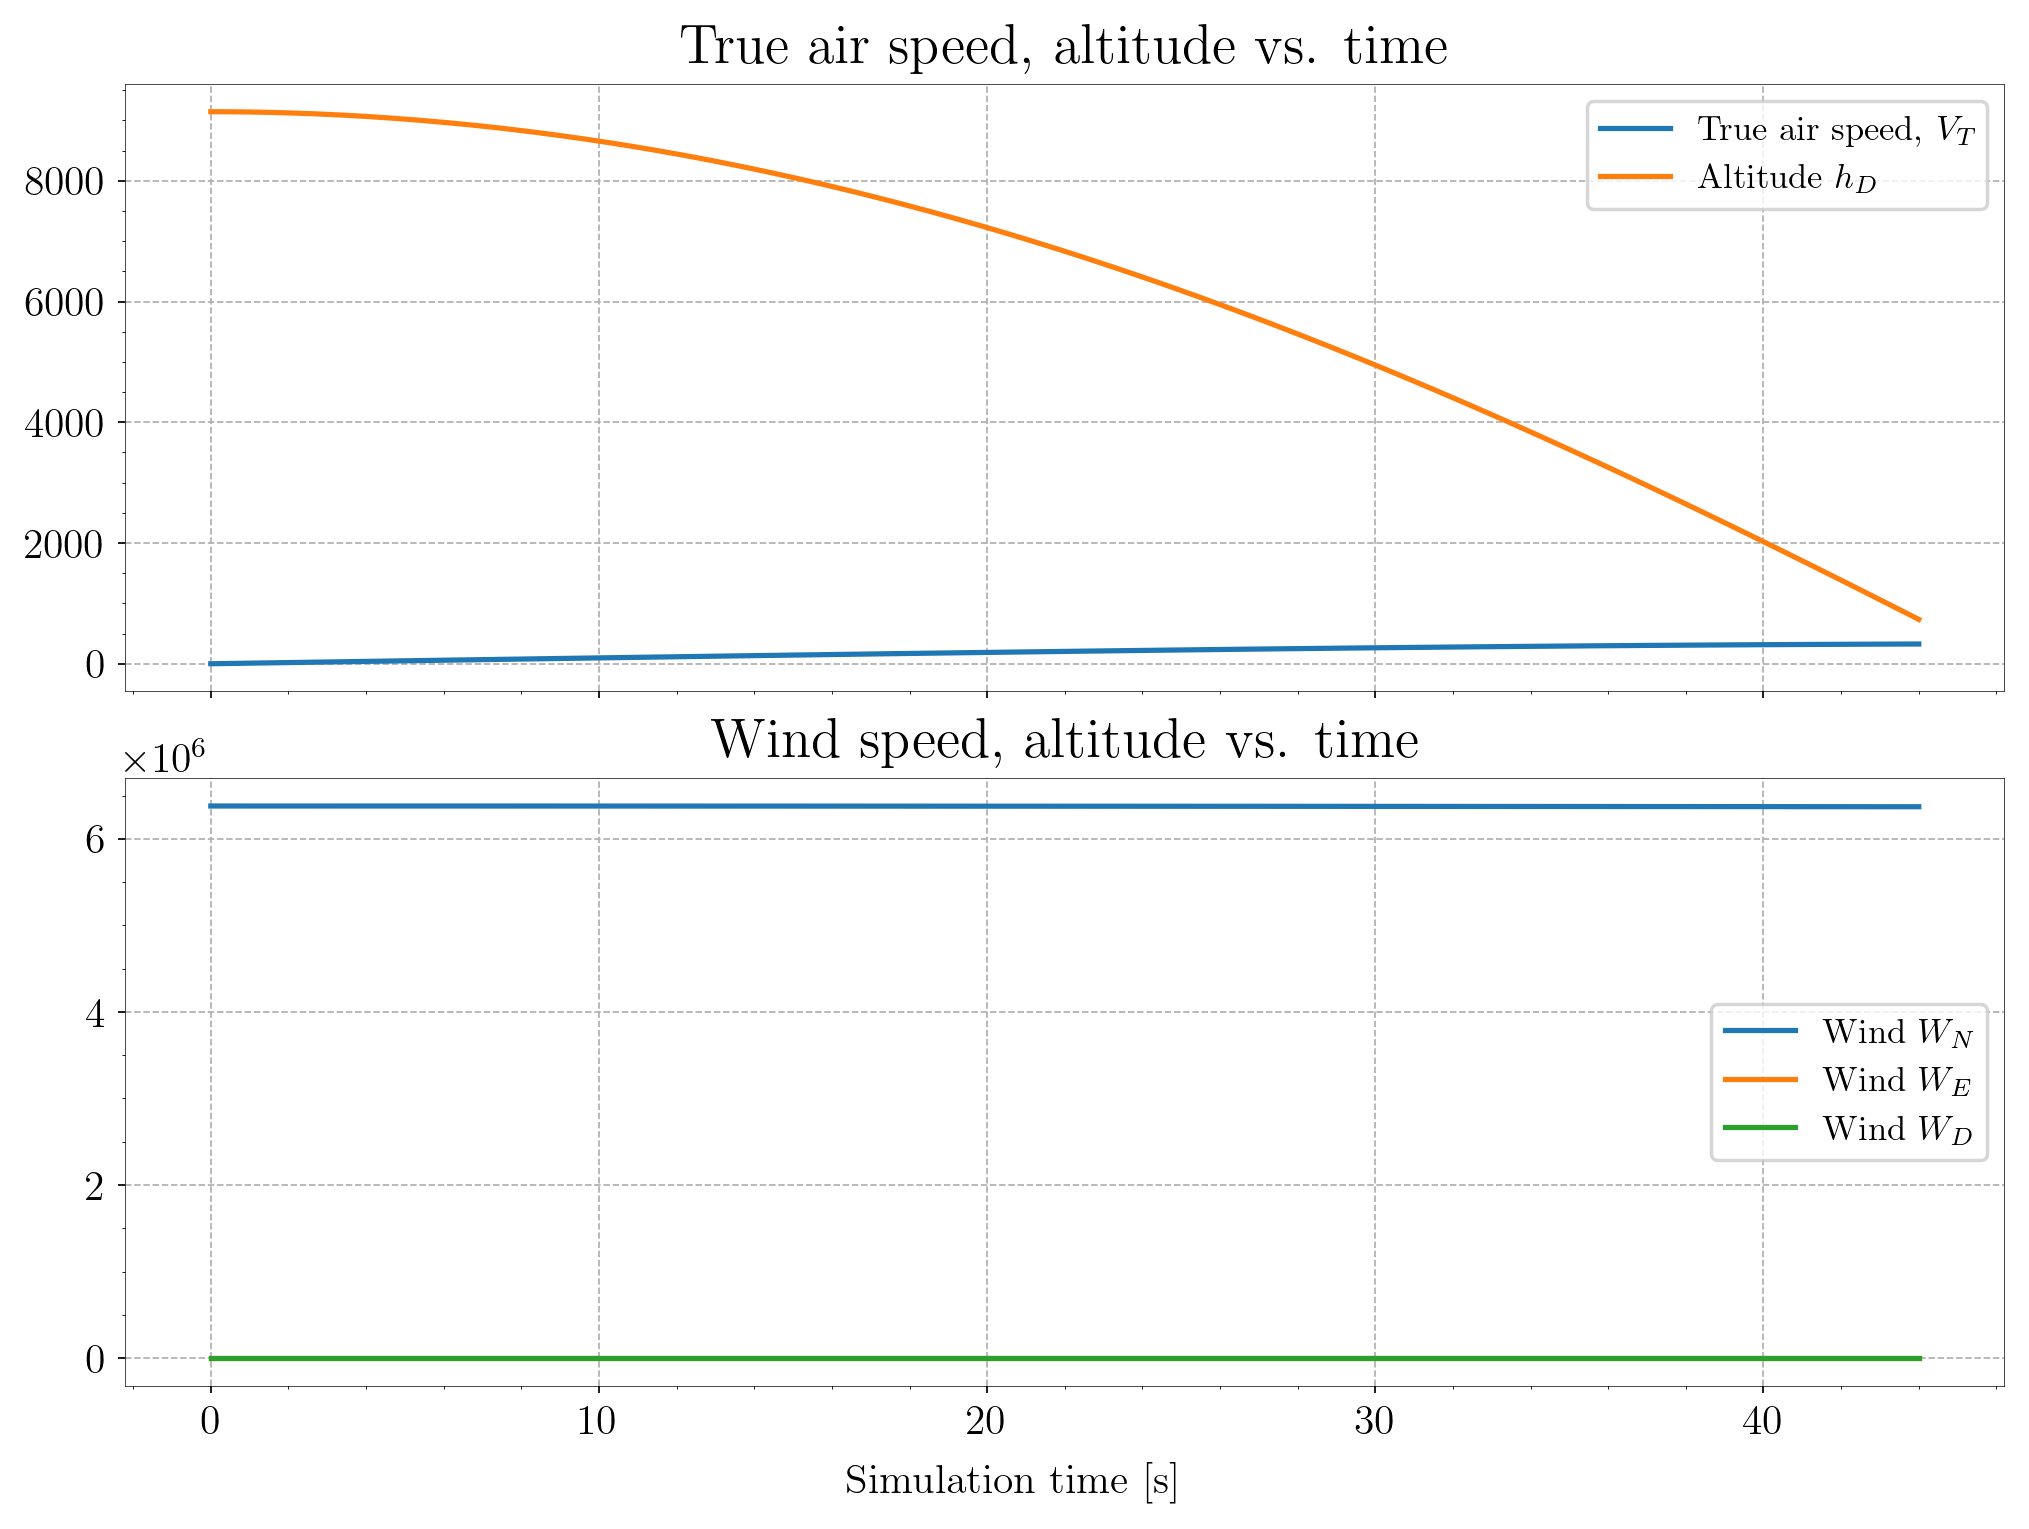

In [3]:
# We want to make a subplot of the following:
# V_T (true air speed) [22]
# Wind, W_N, W_E, W_D [31:34]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True, sharex=True)

ax[0].grid(which="major", linestyle="--", linewidth=0.5)
ax[1].grid(which="major", linestyle="--", linewidth=0.5)

ax[0].plot(
    res.t, res.y[:, 22], label=f"True air speed, {all_cols[22]}"
)  # V_T (true air speed) [22]
ax[0].plot(res.t, res.y[:, 15], label=f"Altitude {all_cols[15]}")  # h (altitude) [15]

for i, wind_dir in enumerate(all_cols[31:34]):
    ax[1].plot(
        res.t, res.y[:, i], label=f"Wind {wind_dir}"
    )  # Wind, W_N, W_E, W_D [31:34]

ax[0].set_title("True air speed, altitude vs. time")
ax[1].set_title("Wind speed, altitude vs. time")

ax[0].legend()
ax[1].legend()

fig.supxlabel("Simulation time [s]")

plt.savefig("report_plots/case_4.pdf")